In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import os
import matplotlib.pyplot as plt
import json
from tqdm.notebook import tqdm
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
def get_adj_matrix(data_df):
    As = []
    for id in tqdm(data_df["id"]):
        a = np.load(f"{path}/bpps/{id}.npy")
        As.append(a)
    As = np.array(As)
    
    ## get adjacent matrix from structure sequence
    sequence_structure_adj = []
    for i in tqdm(range(len(data_df))):
        seq_length = data_df["seq_length"].iloc[i]
        structure = data_df["structure"].iloc[i]
        sequence = data_df["sequence"].iloc[i]

        cue = []
        a_structures = {
            ("A", "U") : np.zeros([seq_length, seq_length]),
            ("C", "G") : np.zeros([seq_length, seq_length]),
            ("U", "G") : np.zeros([seq_length, seq_length]),
            ("U", "A") : np.zeros([seq_length, seq_length]),
            ("G", "C") : np.zeros([seq_length, seq_length]),
            ("G", "U") : np.zeros([seq_length, seq_length]),
        }
        a_structure = np.zeros([seq_length, seq_length])
        for i in range(seq_length):
            if structure[i] == "(":
                cue.append(i)
            elif structure[i] == ")":
                start = cue.pop()
                a_structures[(sequence[start], sequence[i])][start, i] = 1
                a_structures[(sequence[i], sequence[start])][i, start] = 1
        
        a_strc = np.stack([a for a in a_structures.values()], axis = 2)
        a_strc = np.sum(a_strc, axis = 2, keepdims = True)
        sequence_structure_adj.append(a_strc)
    
    sequence_structure_adj = np.array(sequence_structure_adj)
    print(sequence_structure_adj.shape)
    
    ## adjacent matrix based on distance on the sequence
    ## D[i, j] = 1 / (abs(i - j) + 1) ** pow, pow = 1, 2, 4
    idx = np.arange(As.shape[1])
    distance_matrix = []
    for i in range(len(idx)):
        distance_matrix.append(np.abs(idx[i] - idx))

    distance_matrix = np.array(distance_matrix) + 1
    distance_matrix = 1/distance_matrix
    distance_matrix = distance_matrix[None, :,:]
    distance_matrix = np.repeat(distance_matrix, len(As), axis = 0)
    
    Dss = []
    for i in [1, 2, 4]: 
        Dss.append(distance_matrix ** i)
    distance_matrix = np.stack(Dss, axis = 3)
    print(distance_matrix.shape)
    
    adjacency_matrix = np.concatenate([As[:,:,:,None], sequence_structure_adj, distance_matrix], axis = 3).astype(np.float32)
    
    return adjacency_matrix
    
    

In [3]:
def get_node_features(train):
    ## get node features, which is one hot encoded
    mapping = {}
    vocab = ["A", "G", "C", "U"]
    for i, s in enumerate(vocab):
        mapping[s] = [0] * len(vocab)
        mapping[s][i] = 1
    X_node = np.stack(train["sequence"].apply(lambda x : list(map(lambda y : mapping[y], list(x)))))

    mapping = {}
    vocab = ["S", "M", "I", "B", "H", "E", "X"]
    for i, s in enumerate(vocab):
        mapping[s] = [0] * len(vocab)
        mapping[s][i] = 1
    X_loop = np.stack(train["predicted_loop_type"].apply(lambda x : list(map(lambda y : mapping[y], list(x)))))
    
    
    X_node = np.concatenate([X_node, X_loop], axis = 2)
    
    ## interaction
    a = np.sum(X_node * (2 ** np.arange(X_node.shape[2])[None, None, :]), axis = 2)
    vocab = sorted(set(a.flatten()))
    print(vocab)
    ohes = []
    for v in vocab:
        ohes.append(a == v)
    ohes = np.stack(ohes, axis = 2)
    X_node = np.concatenate([X_node, ohes], axis = 2).astype(np.float32)
    
    
    print(X_node.shape)
    return X_node



In [4]:
import tensorflow as tf
from tensorflow.keras import layers as L
import tensorflow_addons as tfa
from tensorflow.keras import backend as K

def mcrmse(t, p, seq_len_target):
    ## calculate mcrmse score by using numpy
    t = t[:, :seq_len_target]
    p = p[:, :seq_len_target]
    
    score = np.mean(np.sqrt(np.mean(np.mean((p - t) ** 2, axis = 1), axis = 0)))
    return score

def attention(x_inner, x_outer, n_factor, dropout):
    x_Q =  L.Conv1D(n_factor, 1, activation='linear', 
                  kernel_initializer='glorot_uniform',
                  bias_initializer='glorot_uniform',
                 )(x_inner)
    x_K =  L.Conv1D(n_factor, 1, activation='linear', 
                  kernel_initializer='glorot_uniform',
                  bias_initializer='glorot_uniform',
                 )(x_outer)
    x_V =  L.Conv1D(n_factor, 1, activation='linear', 
                  kernel_initializer='glorot_uniform',
                  bias_initializer='glorot_uniform',
                 )(x_outer)
    x_KT = L.Permute((2, 1))(x_K)
    res = L.Lambda(lambda c: K.batch_dot(c[0], c[1]) / np.sqrt(n_factor))([x_Q, x_KT])
    att = L.Lambda(lambda c: K.softmax(c, axis=-1))(res)
    att = L.Lambda(lambda c: K.batch_dot(c[0], c[1]))([att, x_V])
    return att

def multi_head_attention(x, y, n_factor, n_head, dropout):
    if n_head == 1:
        att = attention(x, y, n_factor, dropout)
    else:
        n_factor_head = n_factor // n_head
        heads = [attention(x, y, n_factor_head, dropout) for i in range(n_head)]
        att = L.Concatenate()(heads)
        att = L.Dense(n_factor, 
                      kernel_initializer='glorot_uniform',
                      bias_initializer='glorot_uniform',
                     )(att)
    x = L.Add()([x, att])
    x = L.LayerNormalization()(x)
    if dropout > 0:
        x = L.Dropout(dropout)(x)
    return x

def res(x, unit, kernel = 3, rate = 0.1):
    h = L.Conv1D(unit, kernel, 1, padding = "same", activation = None)(x)
    h = L.LayerNormalization()(h)
    h = L.LeakyReLU()(h)
    h = L.Dropout(rate)(h)
    return L.Add()([x, h])

def forward(x, unit, kernel = 3, rate = 0.1):
    h = L.Conv1D(unit, kernel, 1, padding = "same", activation = None)(x)
    h = L.LayerNormalization()(h)
    h = L.Dropout(rate)(h)
    h = L.LeakyReLU()(h)
    h = res(h, unit, kernel, rate)
    return h

def adj_attn(x, adj, unit, n = 2, rate = 0.1):
    x_a = x
    x_as = []
    for i in range(n):
        x_a = forward(x_a, unit)
        x_a = tf.matmul(adj, x_a) ## aggregate neighborhoods
        x_as.append(x_a)
    if n == 1:
        x_a = x_as[0]
    else:
        x_a = L.Concatenate()(x_as)
    x_a = forward(x_a, unit)
    return x_a


def get_base(X_node, adj_matrix):
    ## base model architecture 
    ## node, adj -> middle feature
    
    node = tf.keras.Input(shape = (None, X_node.shape[2]), name = "node")
    adj = tf.keras.Input(shape = (None, None, adj_matrix.shape[3]), name = "adj")
    
    adj_learned = L.Dense(1, "relu")(adj)
    adj_all = L.Concatenate(axis = 3)([adj, adj_learned])
        
    xs = []
    xs.append(node)
    x1 = forward(node, 128, kernel = 3, rate = 0.0)
    x2 = forward(x1, 64, kernel = 6, rate = 0.0)
    x3 = forward(x2, 32, kernel = 15, rate = 0.0)
    x4 = forward(x3, 16, kernel = 30, rate = 0.0)
    x = L.Concatenate()([x1, x2, x3, x4])
    
    for unit in [64, 32]:
        x_as = []
        for i in range(adj_all.shape[3]):
            x_a = adj_attn(x, adj_all[:, :, :, i], unit, rate = 0.0)
            x_as.append(x_a)
        x_c = forward(x, unit, kernel = 30)
        
        x = L.Concatenate()(x_as + [x_c])
        x = forward(x, unit)
        x = multi_head_attention(x, x, unit, 4, 0.0)
        xs.append(x)
        
    x = L.Concatenate()(xs)

    model = tf.keras.Model(inputs = [node, adj], outputs = [x])
    return model


def get_ae_model(base, X_node, adj_matrix):
    ## denoising auto encoder part
    ## node, adj -> middle feature -> node
    
    node = tf.keras.Input(shape = (None, X_node.shape[2]), name = "node")
    adj = tf.keras.Input(shape = (None, None, adj_matrix.shape[3]), name = "adj")

    x = base([L.SpatialDropout1D(0.3)(node), adj])
    x = forward(x, 64, rate = 0.3)
    p = L.Dense(X_node.shape[2], "sigmoid")(x)
    
    loss = - tf.reduce_mean(20 * node * tf.math.log(p + 1e-4) + (1 - node) * tf.math.log(1 - p + 1e-4))
    model = tf.keras.Model(inputs = [node, adj], outputs = [loss])
    
    opt = get_optimizer()
    model.compile(optimizer = opt, loss = lambda t, y : y)
    return model


# loss functions
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=(1))
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=1)

def get_model(base, X_node, adj_matrix, seq_len_target):
    ## regression part
    ## node, adj -> middle feature -> prediction of targets
    
    node = tf.keras.Input(shape = (None, X_node.shape[2]), name = "node")
    adj = tf.keras.Input(shape = (None, None, adj_matrix.shape[3]), name = "adj")
    
    x = base([node, adj])
    x = forward(x, 128, rate = 0.4)
    x = L.Dense(5, None)(x)

    model = tf.keras.Model(inputs = [node, adj], outputs = [x])
    
    opt = get_optimizer()
    def mcrmse_loss(t, y, seq_len_target=seq_len_target):
        ## calculate mcrmse score by using tf
        t = t[:, :seq_len_target]
        y = y[:, :seq_len_target]

        loss = tf.reduce_mean(tf.sqrt(tf.reduce_mean(tf.reduce_mean((t - y) ** 2, axis = 1), axis = 0)))
        return loss
    model.compile(optimizer = opt, loss = mcrmse_loss)
    return model

def get_optimizer():
    adam = tf.optimizers.Adam()
    return adam

In [5]:
def train_auto_encoder(X_node, X_node_pub, X_node_pri, adjacency_matrix, 
                       adjacency_matrix_pub, adjacency_matrix_pri,
                       epochs, epochs_each, batch_size, save_path):
    base = get_base(X_node, adjacency_matrix)
    ae_model = get_ae_model(base, X_node, adjacency_matrix)
    for i in range(epochs//epochs_each):
        print(f"------ {i} ------")
        ae_model.fit([X_node, adjacency_matrix], [X_node[:,0]],
                  epochs = epochs_each,
                  batch_size = batch_size)
        gc.collect()
        print("--- public ---")
        ae_model.fit([X_node_pub, adjacency_matrix_pub], [X_node_pub[:,0]],
                  epochs = ae_epochs_each,
                  batch_size = ae_batch_size)
        print("--- private ---")
        ae_model.fit([X_node_pri, adjacency_matrix_pri], [X_node_pri[:,0]],
                  epochs = ae_epochs_each,
                  batch_size = ae_batch_size)
        gc.collect()
    print("****** save ae model ******")
    
    base.save_weights(save_path)
    

In [6]:
from sklearn.model_selection import KFold
def train_gcn(X_node, adjacency_matrix, seq_len_target, epochs, batch_size,
              model_path, ae_model_path=None, plt_name='withhout_ae', n_fold=5, validation_frequency=1):
    kfold = KFold(n_fold, shuffle = True, random_state = 42)

    legends = []
    for fold, (tr_idx, va_idx) in enumerate(kfold.split(X_node, adjacency_matrix)):

        gc.collect()
        tf.keras.backend.clear_session()
        print(f'\nFold - {fold}\n')
        X_node_tr = X_node[tr_idx]
        X_node_va = X_node[va_idx]
        As_tr = adjacency_matrix[tr_idx]
        As_va = adjacency_matrix[va_idx]
        y_tr = y[tr_idx]
        y_va = y[va_idx]  

        base = get_base(X_node, adjacency_matrix)
        if ae_model_path:
            base.load_weights(ae_model_path)
        model = get_model(base, X_node, adjacency_matrix, seq_len_target)
        filepath_list = model_path.split('.')
        filepath = f'.{filepath_list[1]}_{fold}.{filepath_list[2]}'
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                    filepath=filepath, save_weights_only=True,
                                    monitor='val_loss',mode='min',save_best_only=True)

        history = model.fit([X_node_tr, As_tr], [y_tr],
                            validation_data=([X_node_va, As_va], [y_va]),
                            epochs = epochs,
                            batch_size = batch_size, 
                            validation_freq = validation_frequency,
                            callbacks=[
                                tf.keras.callbacks.ReduceLROnPlateau(),
                                model_checkpoint_callback
                            ]
                       )

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        legends.append(f'loss_fold_{fold}')
        legends.append(f'val_loss_fold_{fold}')

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(legends, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize="x-small")
    plt.savefig("GCN_Model_" + plt_name + ".png", dpi=600)
    plt.show()

In [7]:
denoise = True # if True, use train data whose signal_to_noise > 1

path = "../input/stanfordcovidvaccine"

train = pd.read_json(f"{path}/train.json",lines=True)
if denoise:
    train = train[train.signal_to_noise > 1].reset_index(drop = True)
    
test  = pd.read_json(f"{path}/test.json",lines=True)
test_pub = test[test["seq_length"] == 107]
test_pri = test[test["seq_length"] == 130]
sub = pd.read_csv(f"{path}/sample_submission.csv")

targets = list(sub.columns[1:])
print(targets)

y_train = []
seq_len = train["seq_length"].iloc[0]
seq_len_target = train["seq_scored"].iloc[0]
ignore = -10000
ignore_length = seq_len - seq_len_target
for target in targets:
    y = np.vstack(train[target])
    dummy = np.zeros([y.shape[0], ignore_length]) + ignore
    y = np.hstack([y, dummy])
    y_train.append(y)
y = np.stack(y_train, axis = 2)
y.shape

adjacency_matrix = get_adj_matrix(train)
adjacency_matrix_pub = get_adj_matrix(test_pub)
adjacency_matrix_pri = get_adj_matrix(test_pri)

X_node = get_node_features(train)
X_node_pub = get_node_features(test_pub)
X_node_pri = get_node_features(test_pri)



['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']


  0%|          | 0/2096 [00:00<?, ?it/s]

  0%|          | 0/2096 [00:00<?, ?it/s]

(2096, 107, 107, 1)
(2096, 107, 107, 3)


  0%|          | 0/629 [00:00<?, ?it/s]

  0%|          | 0/629 [00:00<?, ?it/s]

(629, 107, 107, 1)
(629, 107, 107, 3)


  0%|          | 0/3005 [00:00<?, ?it/s]

  0%|          | 0/3005 [00:00<?, ?it/s]

(3005, 130, 130, 1)
(3005, 130, 130, 3)
[17, 18, 20, 24, 33, 34, 36, 40, 65, 66, 68, 72, 129, 130, 132, 136, 257, 258, 260, 264, 513, 514, 516, 520, 1025, 1026, 1028, 1032]
(2096, 107, 39)
[17, 18, 20, 24, 33, 34, 36, 40, 65, 66, 68, 72, 129, 130, 132, 136, 257, 258, 260, 264, 513, 514, 516, 520, 1025, 1026, 1028, 1032]
(629, 107, 39)
[17, 18, 20, 24, 33, 34, 36, 40, 65, 66, 68, 72, 129, 130, 132, 136, 257, 258, 260, 264, 513, 514, 516, 520, 1025, 1026, 1028, 1032]
(3005, 130, 39)



Fold - 0



2022-03-25 03:27:05.641194: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-25 03:27:05.757614: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-25 03:27:05.758453: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-25 03:27:05.761407: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/60


2022-03-25 03:27:40.796666: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


53/53 [==============================] - 45s 225ms/step - loss: 0.9960 - val_loss: 0.4335
Epoch 2/60
53/53 [==============================] - 5s 103ms/step - loss: 0.5057 - val_loss: 0.3801
Epoch 3/60
53/53 [==============================] - 6s 104ms/step - loss: 0.4191 - val_loss: 0.3708
Epoch 4/60
53/53 [==============================] - 5s 99ms/step - loss: 0.3976 - val_loss: 0.3715
Epoch 5/60
53/53 [==============================] - 5s 97ms/step - loss: 0.3865 - val_loss: 0.3600
Epoch 6/60
53/53 [==============================] - 6s 106ms/step - loss: 0.3743 - val_loss: 0.3507
Epoch 7/60
53/53 [==============================] - 5s 96ms/step - loss: 0.3583 - val_loss: 0.3379
Epoch 8/60
53/53 [==============================] - 5s 104ms/step - loss: 0.3490 - val_loss: 0.3279
Epoch 9/60
53/53 [==============================] - 5s 98ms/step - loss: 0.3358 - val_loss: 0.3085
Epoch 10/60
53/53 [==============================] - 5s 100ms/step - loss: 0.3256 - val_loss: 0.3124
Epoch 11/60
5

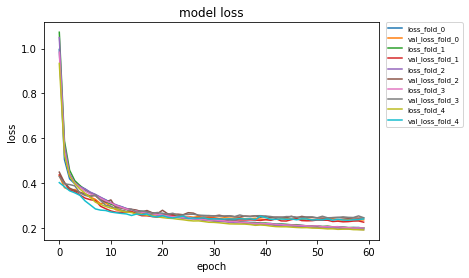

In [8]:
epochs = 60
batch_size = 32
n_folds = 5

model_path = "./model_without_ae.h5"
train_gcn(X_node, adjacency_matrix, seq_len_target, epochs, batch_size,
              model_path, n_fold=n_folds)

In [9]:

p_pub = 0
p_pri = 0
base = get_base(X_node, adjacency_matrix_pub)
model = get_model(base, X_node, adjacency_matrix_pub, seq_len_target)

for fold in range(n_folds):
    filepath_list = model_path.split('.')
    filepath = f'.{filepath_list[1]}_{fold}.{filepath_list[2]}'
    model.load_weights(filepath)
    p_pub += model.predict([X_node_pub, adjacency_matrix_pub]) / n_folds
    p_pri += model.predict([X_node_pri, adjacency_matrix_pri]) / n_folds

for i, target in enumerate(targets):
    test_pub[target] = [list(p_pub[k, :, i]) for k in range(p_pub.shape[0])]
    test_pri[target] = [list(p_pri[k, :, i]) for k in range(p_pri.shape[0])]

preds_ls = []
for df, preds in [(test_pub, p_pub), (test_pri, p_pri)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]

        single_df = pd.DataFrame(single_pred, columns=targets)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        preds_ls.append(single_df)

preds_df = pd.concat(preds_ls)
preds_df.to_csv("submission_without_ae.csv", index = False)
preds_df.head()

2022-03-25 04:02:18.706226: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1015690000 exceeds 10% of free system memory.
2022-03-25 04:02:19.782146: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1015690000 exceeds 10% of free system memory.
2022-03-25 04:02:31.872093: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1015690000 exceeds 10% of free system memory.
2022-03-25 04:02:32.963620: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1015690000 exceeds 10% of free system memory.
2022-03-25 04:02:38.654251: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1015690000 exceeds 10% of free system memory.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C,id_seqpos
0,0.834638,0.643975,1.810169,0.521408,0.728140,id_00073f8be_0
1,2.670516,3.347618,4.730049,3.366072,2.934767,id_00073f8be_1
2,1.537714,0.560412,0.812539,0.765522,0.760551,id_00073f8be_2
3,1.393927,1.100546,1.232004,1.596116,1.557553,id_00073f8be_3
4,0.848779,0.635945,0.656471,0.882945,0.830184,id_00073f8be_4


In [10]:
ae_epochs = 20 # epoch of training of denoising auto encoder
ae_epochs_each = 5 # epoch of training of denoising auto encoder each time.                  
ae_batch_size = 32
ae_path = "./base_ae"
train_auto_encoder(X_node, X_node_pub, X_node_pri, adjacency_matrix, 
                    adjacency_matrix_pub, adjacency_matrix_pri, ae_epochs, ae_epochs_each, 
                   ae_batch_size, ae_path,)

------ 0 ------
Epoch 1/5
66/66 [==============================] - 32s 99ms/step - loss: 0.9203
Epoch 2/5
66/66 [==============================] - 6s 95ms/step - loss: 0.3167
Epoch 3/5
66/66 [==============================] - 6s 86ms/step - loss: 0.1662
Epoch 4/5
66/66 [==============================] - 6s 89ms/step - loss: 0.1156
Epoch 5/5
66/66 [==============================] - 7s 106ms/step - loss: 0.0854
--- public ---
Epoch 1/5
20/20 [==============================] - 3s 177ms/step - loss: 0.0757
Epoch 2/5
20/20 [==============================] - 2s 105ms/step - loss: 0.0683
Epoch 3/5
20/20 [==============================] - 2s 105ms/step - loss: 0.0603
Epoch 4/5
20/20 [==============================] - 2s 86ms/step - loss: 0.0603
Epoch 5/5
20/20 [==============================] - 2s 86ms/step - loss: 0.0568
--- private ---
Epoch 1/5
94/94 [==============================] - 27s 106ms/step - loss: 0.0573
Epoch 2/5
94/94 [==============================] - 9s 98ms/step - loss: 0.044


Fold - 0

Epoch 1/60
53/53 [==============================] - 36s 208ms/step - loss: 0.9329 - val_loss: 0.3799
Epoch 2/60
53/53 [==============================] - 6s 106ms/step - loss: 0.5023 - val_loss: 0.3453
Epoch 3/60
53/53 [==============================] - 5s 96ms/step - loss: 0.3872 - val_loss: 0.3232
Epoch 4/60
53/53 [==============================] - 8s 147ms/step - loss: 0.3455 - val_loss: 0.3133
Epoch 5/60
53/53 [==============================] - 6s 115ms/step - loss: 0.3221 - val_loss: 0.3041
Epoch 6/60
53/53 [==============================] - 5s 95ms/step - loss: 0.3068 - val_loss: 0.2822
Epoch 7/60
53/53 [==============================] - 6s 108ms/step - loss: 0.2941 - val_loss: 0.2795
Epoch 8/60
53/53 [==============================] - 5s 98ms/step - loss: 0.2868 - val_loss: 0.2716
Epoch 9/60
53/53 [==============================] - 5s 99ms/step - loss: 0.2807 - val_loss: 0.2687
Epoch 10/60
53/53 [==============================] - 5s 96ms/step - loss: 0.2756 - val_loss:

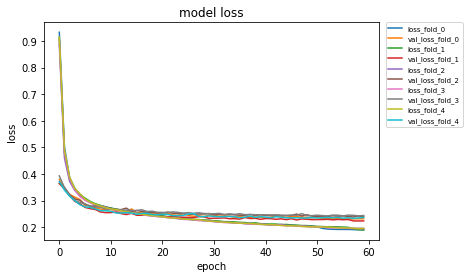

In [11]:

model_path = "./model_with_ae.h5"
train_gcn(X_node, adjacency_matrix, seq_len_target, epochs, batch_size,
              model_path, ae_model_path=ae_path, plt_name='with_ae', n_fold=n_folds)

In [12]:
p_pub = 0
p_pri = 0
base = get_base(X_node, adjacency_matrix_pub)
model = get_model(base, X_node, adjacency_matrix_pub, seq_len_target)

for fold in range(n_folds):
    filepath_list = model_path.split('.')
    filepath = f'.{filepath_list[1]}_{fold}.{filepath_list[2]}'
    model.load_weights(filepath)
    p_pub += model.predict([X_node_pub, adjacency_matrix_pub]) / n_folds
    p_pri += model.predict([X_node_pri, adjacency_matrix_pri]) / n_folds

for i, target in enumerate(targets):
    test_pub[target] = [list(p_pub[k, :, i]) for k in range(p_pub.shape[0])]
    test_pri[target] = [list(p_pri[k, :, i]) for k in range(p_pri.shape[0])]

preds_ls = []
for df, preds in [(test_pub, p_pub), (test_pri, p_pri)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]

        single_df = pd.DataFrame(single_pred, columns=targets)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        preds_ls.append(single_df)

preds_df = pd.concat(preds_ls)
preds_df.to_csv("submission_with_ae.csv", index = False)
preds_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C,id_seqpos
0,0.788231,0.659626,1.849655,0.581575,0.783443,id_00073f8be_0
1,2.407089,3.291145,4.640380,3.363774,2.804014,id_00073f8be_1
2,1.557328,0.639622,0.826673,0.836256,0.808098,id_00073f8be_2
3,1.339339,1.171236,1.275291,1.707872,1.649982,id_00073f8be_3
4,0.820112,0.646540,0.660821,0.906517,0.854045,id_00073f8be_4
